# Descan + STEM Overfocus procedure

Suppose we want to calibriate and verify the experimental microscope parameters of a fourdstem dataset which suffers from descan error - 

This notebook shows that using three vacuum reference datasets, taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings), one can characterise first the descan error, and semi-convergence angle of the beam. 

Then using a back reconstruction step with the known descan error and semi-convergence values, and the 4D stem experimental dataset, we can determine the scan step, scan rotation, detector flip and defocus values of the microscope system. 

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy
import jax.numpy as jnp
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF
from skimage.measure import label, regionprops
from concurrent.futures import ProcessPoolExecutor

In [3]:
import microscope_calibration.components as comp
from microscope_calibration.model import ModelParameters, DescannerErrorParameters
from microscope_calibration.generate import generate_dataset_from_image
from microscope_calibration.interactive import interactive_window
from microscope_calibration.fitting import fit_descan_error_matrix
from microscope_calibration.stemoverfocus import solve_model_fourdstem_wrapper
from microscope_calibration.model import Model, create_stem_model

In [4]:
ctx = lt.Context.make_with("inline")

This notebook assumes you know the *pixel size* of your detector, and have acquired three overfocus dataset acquired at a *known camera lengths*, calibrated using some other method.

To begin we will generate these data so that this notebook is standalone.

## 0 - Generate data

In [5]:
sample_image = plt.imread(r"SilverFast_Resolution_Target_USAF_1951.png")[:, :, 0]
sample_image = sample_image[1:-1, 1:-1]
# sample_image = np.ones_like(sample_image)
sample_image.shape

(206, 213)

In [6]:
# np.random.seed(1)  # For reproducibility
descan_error = DescannerErrorParameters(
        pxo_pxi=np.random.uniform(-5, 5),
        pxo_pyi=np.random.uniform(-5, 5),
        pyo_pxi=np.random.uniform(-5, 5),
        pyo_pyi=np.random.uniform(-5, 5),
        sxo_pxi=np.random.uniform(-5, 5),
        sxo_pyi=np.random.uniform(-5, 5),
        syo_pxi=np.random.uniform(-5, 5),
        syo_pyi=np.random.uniform(-5, 5),
        offpxi=np.random.uniform(-0.04, 0.04),
        offsxi=np.random.uniform(-0.04, 0.04),
        offpyi=np.random.uniform(-0.04, 0.04),
        offsyi=np.random.uniform(-0.04, 0.04)
    )

descan_error = DescannerErrorParameters(*descan_error)
params = ModelParameters(
    semi_conv=0.1,
    defocus=0.1,  # Distance from the crossover to the sample
    camera_length=1.0,  # Distance from the point source to the detector
    scan_shape=(32, 32),  # YX!
    det_shape=(128, 128),  # YX!
    scan_step=(0.001, 0.001),  # YX!
    det_px_size=(0.01, 0.01),  # YX!
    scan_rotation=0.,
    descan_error=descan_error,
    flip_y=False,
)

In [7]:
datasets = {}
clengths = (0.5, 1.0, 1.5)
with ProcessPoolExecutor(max_workers=3) as p:
    futures = []
    for cl in clengths:
        _params = copy.deepcopy(params)
        _params["camera_length"] = cl
        f = p.submit(generate_dataset_from_image, _params, sample_image, method="linear", progress=False)
        futures.append(f)
    
    for f, cl in zip(futures, clengths):
        data = f.result()
        datasets[cl] = ctx.load("memory", data=data, num_partitions=1)

## 1 - Determine approximate semiconvergence angle

We can determine an approximate $\alpha$ by measuring the radius of the transmitted beam in pixels, and using the pixel size and camera length to measure the angle of the triangle with origin at the point source.

In [8]:
guesses = []
for cl in datasets.keys():
    det_px_size = min(params["det_px_size"])
    sy, sx = datasets[cl].shape.nav
    pick_a = ctx.create_pick_analysis(datasets[cl], sx // 2, sy // 2)
    frame = ctx.run(pick_a).intensity.raw_data
    radius = (
        max(
            regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
        ).equivalent_diameter
        / 2
    )
    semi_conv_guess = float(np.atan2(radius * det_px_size, cl)) # Still in small angle approximation, so atan2 should make no difference.
    guesses.append(semi_conv_guess)
    print(f"Camera length: {cl}, Approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

semi_conv_guess = np.mean(guesses)
print(f"Average approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

Camera length: 0.5, Approximte semiconv: 0.109, True value 0.1
Camera length: 1.0, Approximte semiconv: 0.099, True value 0.1
Camera length: 1.5, Approximte semiconv: 0.094, True value 0.1
Average approximte semiconv: 0.100, True value 0.1


## 2 - Visualise descan error

Just for visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

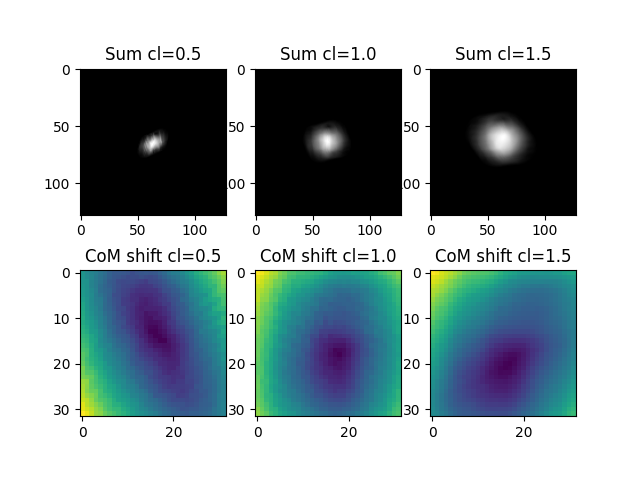

In [9]:
fig, axs = plt.subplots(2, 3)

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is more descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

## 3 - Determine parameters ignoring descan error

Even in the presence of descan error, we can reconstruct a single dataset to determine the scan geometry and defocus. The result will be distorted, but should still be sharp when the right parameters are found. We start from a scan step which is know approximately, but with no knowledge of the scan step or defocus value:

In [10]:
guess_params = copy.deepcopy(params)
cl = 1.0
guess_params["camera_length"] = cl
guess_params["semi_conv"] = semi_conv_guess
guess_params["defocus"] = 0.
guess_params["scan_step"] = np.asarray(guess_params["scan_step"]) * np.random.uniform(0.8, 1.2)
guess_params["scan_rotation"] = 0.
interactive_window(ctx, datasets[cl], guess_params)

# guess_params = copy.deepcopy(params)
# cl = 1.0
# guess_params["camera_length"] = cl
# guess_params["semi_conv"] = params["semi_conv"]
# guess_params["defocus"] = params["defocus"]
# guess_params["scan_step"] = np.asarray(params["scan_step"])
# guess_params["scan_rotation"] = 0.
# interactive_window(ctx, datasets[cl], guess_params)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e65da7dc-cfa0-49e4-a039-98f3d03f0666': {'version…


Now we have an estimate of the CoM shift for each dataset we can compute a point virtual detector image with the most basic kind of error compensation: Simply fitting a 3x3 affine transform matrix to the pixel shifts, and using that to registrate each disk back to the centre of the detector. The drawback is we must compute a new affine transform for each camera length, and we do not correct for astigmatism in the disks.

## 4 - Descan error fit

With these parameters determined and more certainty on the input coordinate scan coordinates, we can then solve simultaneously on the three datasets to determine the descan error matrix that describes the microscope experiment. This descan error matrix will determine the propagation matrix of the microscope that describes the descan error dependance on camera length, and enable us to correct for astigmatism in the disks also.

In [11]:
scan_coords = []
det_coords = []
b_vals = []
for camera_length, ds in datasets.items():
    crossover_z = jnp.zeros((1))
    ScanGrid = comp.ScanGrid(
        z=jnp.array(params['defocus']),
        scan_step=params['scan_step'],
        scan_shape=ds.shape.nav.to_tuple(),
        scan_rotation=params['scan_rotation'],
    )
    scan_coords.append(ScanGrid.coords)
    Detector = comp.Detector(
        z=jnp.array(camera_length),
        det_shape=ds.shape.sig.to_tuple(),
        det_pixel_size=params['det_px_size'],
        flip_y=params['flip_y'],
    )
    yx_px_det = com_r[camera_length]["raw_com"].data.reshape(-1, 2)
    det_coords.append(np.stack(Detector.pixels_to_metres(yx_px_det.T), axis=1))
    b_vals.append(camera_length - params['defocus'])

bvals = np.concatenate(
    tuple(np.full((c.shape[0],), b) for b, c in zip(b_vals, scan_coords))
)
scan_coords = np.concatenate(scan_coords, axis=0)
det_coords = np.concatenate(det_coords, axis=0)

mask = ~(np.all(det_coords == 0.0, axis=1))
bvals = bvals[mask]
scan_coords = scan_coords[mask]
det_coords = det_coords[mask]

print(bvals.shape)


(3072,)


In [12]:
fit_descan_error = fit_descan_error_matrix(scan_coords, det_coords, bvals,
                              num_samples=len(bvals))

print("Fitted versus Known descan error parameters:")
print(f"{'Parameter':20s}{'Fitted Value':25s}{'Known Value':25s}")
print("-" * 70)
for key in fit_descan_error._fields:
    fitted_val = getattr(fit_descan_error, key)
    known_val = getattr(fit_descan_error, key)
    print(f"{key:20s}{f'{fitted_val:+.3f}':25s}{f'{known_val:+.3f}':25s}")


Fitted versus Known descan error parameters:
Parameter           Fitted Value             Known Value              
----------------------------------------------------------------------
pxo_pxi             +3.617                   +3.617                   
pxo_pyi             +2.608                   +2.608                   
pyo_pxi             +2.453                   +2.453                   
pyo_pyi             +2.049                   +2.049                   
sxo_pxi             +2.362                   +2.362                   
sxo_pyi             -4.526                   -4.526                   
syo_pxi             -1.080                   -1.080                   
syo_pyi             +1.984                   +1.984                   
offpxi              +0.007                   +0.007                   
offpyi              -0.026                   -0.026                   
offsxi              -0.018                   -0.018                   
offsyi              +0.035      

## Show final result

In [14]:
cl = 1.0
ds = datasets[cl]
semiconv = guess_params["semi_conv"]
det_px_size = np.asarray(guess_params["det_px_size"])
defocus = guess_params["defocus"]  # Distance from the crossover to the sample
scan_step = np.asarray(guess_params["scan_step"])  # YX!
scan_rotation = guess_params["scan_rotation"]
flip_y = guess_params["flip_y"]

model_parameters = {
    "semi_conv": semiconv,
    "defocus": defocus,  # Distance from the crossover to the sample
    "camera_length": cl,  # Distance from the sample to the detector
    "scan_shape": ds.shape.nav,  # YX!
    "det_shape": ds.shape.sig,  # YX!
    "scan_step": scan_step,  # YX!
    "det_px_size": det_px_size,  # YX!
    "scan_rotation": scan_rotation,
    "descan_error": fit_descan_error,
    "flip_y": flip_y,
    "px_shifts": None,  # YX!
}
interactive_window(ctx, ds, model_parameters)

BokehModel(combine_events=True, render_bundle={'docs_json': {'aacc8cee-ca2a-4c60-beed-86088b518df8': {'version…